In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from obspy import read
from code_tools.model.multitask_build_model import unets as detector_unets
from code_tools.model.build_model import unets as picker_unets
from code_tools.data_utils import stream_standardize
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

## 1. load models
picker = picker_unets().build_attR2unet(
    './pretrained_model/paper_model_ARRU_20s/train.hdf5')
detector = detector_unets().build_attR2unet(
    './pretrained_model/multitask_ARRU_20s/train.hdf5')
#print(detector.summary())

In [2]:
## 2. read an earthquake event 
st = read()
stt = st[0].stats.starttime
ent = stt + 20
st = st.slice(stt, ent)
st = stream_standardize(st)
# Z-score standardize before making predictions
batch_data = np.array([i.data for i in st]).T[np.newaxis, ...]
# shape (1, 2001, 3)
print("shape of input data: (batch_size, data_length, channel):", batch_data.shape)

shape of input data: (batch_size, data_length, channel): (1, 2001, 3)


In [3]:
## 3. making predictions
# picker predictions
picker_pick = picker.predict(batch_data)
# detector predictions
detector_pick, detector_mask = detector.predict(batch_data)

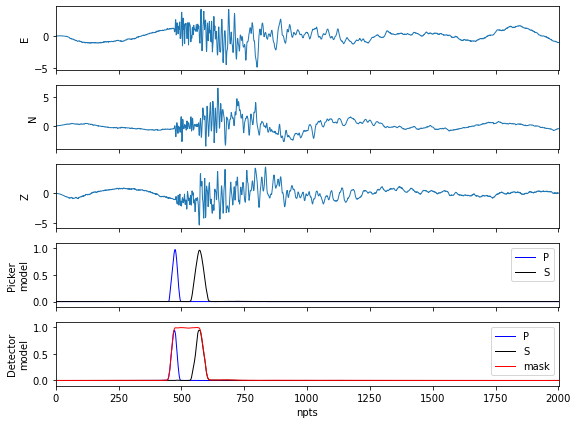

In [4]:
## 4. plot predictions
fig, ax = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
# waveforms
wf_data = [batch_data[0].T[0], batch_data[0].T[1], batch_data[0].T[2]]
wf_ylbl = ['E', 'N', 'Z']
for i in range(3):
    ax[i].plot(wf_data[i], linewidth=1)
    ax[i].set_ylabel(wf_ylbl[i])
    ax[i].set_xlim(0, 2001)
    #ax[i].set_xticks([])
# picker predictions
ax[3].plot(picker_pick[0].T[0], linewidth=1, color='b', label='P')
ax[3].plot(picker_pick[0].T[1], linewidth=1, color='k', label='S')
ax[3].set_ylim(-0.1, 1.1)
ax[3].set_ylabel('Picker\nmodel')
ax[3].legend()
ax[3].set_xlim(0, 2001)
# detector predictions
ax[4].plot(detector_pick[0].T[0], linewidth=1, color='b', label='P')
ax[4].plot(detector_pick[0].T[1], linewidth=1, color='k', label='S')
ax[4].plot(detector_mask[0].T[0], linewidth=1, color='r', label='mask')
ax[4].set_ylim(-0.1, 1.1)
ax[4].set_ylabel('Detector\nmodel')
ax[4].set_xlabel('npts')
ax[4].legend()
ax[4].set_xlim(0, 2001)
plt.tight_layout()
plt.show()